In [ ]:
# Dataset Used : https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
base_csv = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
X,y  = df['review'],df['sentiment']
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

In [5]:
dd = pd.Series(y_train).value_counts()
dd

positive    18750
negative    18750
Name: sentiment, dtype: int64

In [6]:
def preprocessing(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s

In [7]:
def tokenize(x_train,y_train,x_val,y_val):
    word_list = []
    
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocessing(word)
            if word not in stop_words and word!='':
                word_list.append(word)
    
    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    final_list_train,final_list_test = [],[]
    
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocessing(word)] for word in sent.lower().split() 
                                     if preprocessing(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocessing(word)] for word in sent.lower().split() 
                                    if preprocessing(word) in onehot_dict.keys()])
    encoded_train = [1 if label=='positive' else 0 for label in y_train]
    encoded_test = [1 if label=='positive' else 0 for label in y_val]
    
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [8]:
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
print('Vocab Size',len(vocab))

Vocab Size 1000


In [10]:
def padding_(sentences,seq_len):
    features = np.zeros((len(sentences),seq_len),dtype=int)
    for ii,review in enumerate(sentences):
        if len(review) != 0:
            features[ii,-len(review):] = np.array(review)[:seq_len]
    return features       

In [11]:
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [12]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

batch_size = 50

train_loader = DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_loader = DataLoader(valid_data,shuffle=True,batch_size=batch_size)

In [13]:
dataiter = iter(train_loader)
sample_x,sample_y = next(dataiter)

print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 234, 328,   9],
        [  0,   0,   0,  ...,  57, 552,  47],
        [  0,   0,   0,  ..., 989, 163, 141],
        ...,
        [  0,   0,   0,  ..., 407,   3,  87],
        [  0,   0,   0,  ..., 588, 731, 509],
        [  0,   0,   0,  ..., 211, 215, 790]])
Sample input: 
 tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0])


In [14]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
        
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,num_layers=no_layers,batch_first=True)
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc = nn.Linear(self.hidden_dim,output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out,hidden = self.lstm(embeds,hidden)
        
        lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size,-1)
        sig_out = sig_out[:,-1]
        
        return sig_out,hidden

    
    def init_hidden(self,batch_size):
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [15]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [18]:
lr = 0.001
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return np.sum(pred.detach().cpu().numpy()==label.squeeze().detach().cpu().numpy())

In [19]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        accuracy = acc(output,labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.5449287031094233 val_loss : 0.4169483481645584
train_accuracy : 71.77333333333334 val_accuracy : 81.0
Validation loss decreased (inf --> 0.416948).  Saving model ...
Epoch 2
train_loss : 0.40416183771689734 val_loss : 0.36677558767795565
train_accuracy : 82.096 val_accuracy : 84.336
Validation loss decreased (0.416948 --> 0.366776).  Saving model ...
Epoch 3
train_loss : 0.34233903951446215 val_loss : 0.3318478662967682
train_accuracy : 85.45066666666666 val_accuracy : 85.44800000000001
Validation loss decreased (0.366776 --> 0.331848).  Saving model ...
Epoch 4
train_loss : 0.31464054755369825 val_loss : 0.32579691264033317
train_accuracy : 86.41066666666667 val_accuracy : 86.16
Validation loss decreased (0.331848 --> 0.325797).  Saving model ...
Epoch 5
train_loss : 0.28715336074431735 val_loss : 0.3224939587712288
train_accuracy : 87.67466666666667 val_accuracy : 86.056
Validation loss decreased (0.325797 --> 0.322494).  Saving model ...


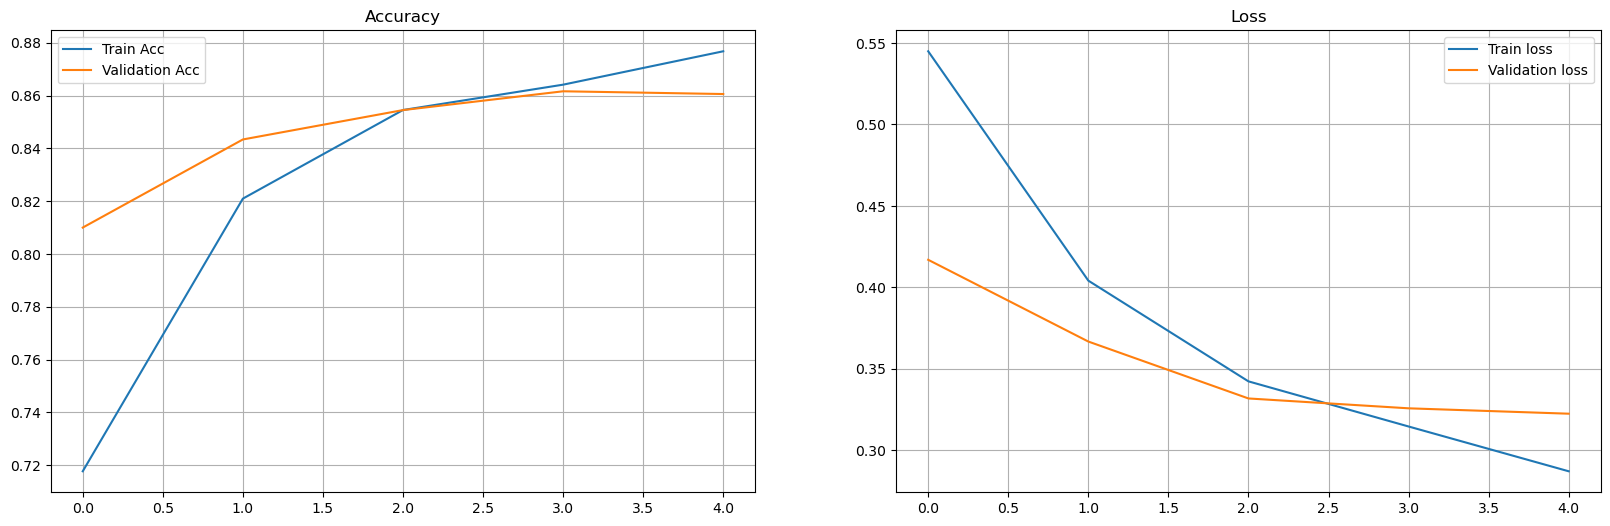

In [20]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [23]:
def predict_text(text):
        word_seq = np.array([vocab[preprocessing(word)] for word in text.split() 
                         if preprocessing(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [24]:
index = 3
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.
Actual sentiment is  : negative
Predicted sentiment is negative with a probability of 0.5129942893981934
